# G-band magnitude/flux corrections for 6-p Gaia EDR3 sources

This notebook contains example Python to correct the Gaia EDR3 G-banf fluxes or magnitudes for sources with 6-parameter astrometric solutions.

The input data was retrieved from the Gaia EDR3 archive with the following query:
```
select source_id, astrometric_params_solved, bp_rp, phot_g_mean_mag, phot_g_mean_flux
from user_edr3int4.gaia_source
where random_index between 5000000 and 5999999
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table

## Define the function that calculates the magnitude and flux corrections

In [2]:
def correct_gband(bp_rp, astrometric_params_solved, phot_g_mean_mag, phot_g_mean_flux):
    """
    Correct the G-band fluxes and magnitudes for the input list of Gaia EDR3 data.
    
    Parameters
    ----------
    
    bp_rp: float, array_like
        The (BP-RP) colour listed in the Gaia EDR3 archive.
    astrometric_params_solved: int, array_like
        The astrometric solution type listed in the Gaia EDR3 archive.
    phot_g_mean_mag: float, array_like
        The G-band magnitude as listed in the Gaia EDR3 archive.
    phot_g_mean_flux: float, array_like
        The G-band flux as listed in the Gaia EDR3 archive.
        
    Returns
    -------
    
    The corrected G-band magnitudes and fluxes. The corrections are only applied to
    sources with a 6-parameter astrometric solution fainter than G=13, for which a
    (BP-RP) colour is available.
    
    Example
    -------
    
    gmag_corr, gflux_corr = correct_gband(bp_rp, astrometric_params_solved, phot_g_mean_mag, phot_g_mean_flux)
    """

    if np.isscalar(bp_rp) or np.isscalar(astrometric_params_solved) or np.isscalar(phot_g_mean_mag) \
                    or np.isscalar(phot_g_mean_flux):
        bp_rp = np.float64(bp_rp)
        astrometric_params_solved = np.int64(astrometric_params_solved)
        phot_g_mean_mag = np.float64(phot_g_mean_mag)
        phot_g_mean_flux = np.float64(phot_g_mean_flux)
    
    if not (bp_rp.shape == astrometric_params_solved.shape == phot_g_mean_mag.shape == phot_g_mean_flux.shape):
        raise ValueError('Function parameters must be of the same shape!')
    
    do_not_correct = np.isnan(bp_rp) | (phot_g_mean_mag<=13) | (astrometric_params_solved != 95)
    bright_correct = np.logical_not(do_not_correct) & (phot_g_mean_mag>13) & (phot_g_mean_mag<=16)
    faint_correct = np.logical_not(do_not_correct) & (phot_g_mean_mag>16)
    bp_rp_c = np.clip(bp_rp, 0.25, 3.0)
    
    correction_factor = np.ones_like(phot_g_mean_mag)
    correction_factor[faint_correct] = 1.00525 - 0.02323*bp_rp_c[faint_correct] + \
        0.01740*np.power(bp_rp_c[faint_correct],2) - 0.00253*np.power(bp_rp_c[faint_correct],3)
    correction_factor[bright_correct] = 1.00876 - 0.02540*bp_rp_c[bright_correct] + \
        0.01747*np.power(bp_rp_c[bright_correct],2) - 0.00277*np.power(bp_rp_c[bright_correct],3)
    
    gmag_corrected = phot_g_mean_mag - 2.5*np.log10(correction_factor)
    gflux_corrected = phot_g_mean_flux * correction_factor
    
    return gmag_corrected, gflux_corrected

## Verify that the code works on the example data from the archive

The plot below is only a visual confirmation that the corrections are applied as expected for the different $G$ and colour ranges.

In [3]:
edr3data = Table.read('GCorrection_inputs.fits', format='fits')

gmag_corrected, gflux_corrected = correct_gband(edr3data['bp_rp'], edr3data['astrometric_params_solved'],
                                                edr3data['phot_g_mean_mag'], edr3data['phot_g_mean_flux'])

print(f"Number of sources with G=null: {edr3data['phot_g_mean_mag'][np.isnan(edr3data['phot_g_mean_mag'])].size}")
print(f"Number of sources with G_corr=null: {gmag_corrected[np.isnan(gmag_corrected)].size}")
print(f"Number of sources with Gflux_corr=null: {gflux_corrected[np.isnan(gflux_corrected)].size}")
print()

not_corrected = np.isnan(edr3data['bp_rp']) | (edr3data['phot_g_mean_mag']<=13) | \
    (edr3data['astrometric_params_solved'] != 95)
faint_corrected = np.logical_not(not_corrected) & (edr3data['phot_g_mean_mag']>16)
bright_corrected = np.logical_not(not_corrected) & (edr3data['phot_g_mean_mag']>13) & \
    (edr3data['phot_g_mean_mag']<=16)

deltag = gmag_corrected - edr3data['phot_g_mean_mag']
fratio = gflux_corrected / edr3data['phot_g_mean_flux']

print(f"Range in delta_G where no correction is expected (should be all zeros): \
    {np.nanmin(deltag[not_corrected])}--{np.nanmax(deltag[not_corrected])}")
print(f"Range in flux ratio where no correction is expected (should be all ones): \
    {np.nanmin(fratio[not_corrected])}--{np.nanmax(fratio[not_corrected])}")

Number of sources with G=null: 2939
Number of sources with G_corr=null: 2939
Number of sources with Gflux_corr=null: 2939

Range in delta_G where no correction is expected (should be all zeros):     0.0--0.0
Range in flux ratio where no correction is expected (should be all ones):     1.0--1.0


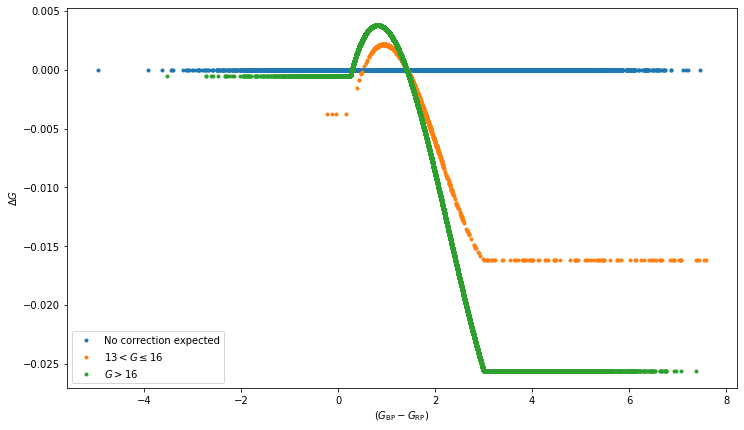

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(12,7))

ax.plot(edr3data['bp_rp'][not_corrected], deltag[not_corrected], '.', label='No correction expected')
ax.plot(edr3data['bp_rp'][bright_corrected], deltag[bright_corrected], '.', label='$13<G\leq16$')
ax.plot(edr3data['bp_rp'][faint_corrected], deltag[faint_corrected], '.', label='$G>16$')
ax.set_xlabel('$(G_\mathrm{BP}-G_\mathrm{RP}$)')
ax.set_ylabel('$\Delta G$')
ax.legend(loc='lower left')

plt.show()

## Verify that the code works for scalar inputs

Also verify that the code throws the expected exception when input shapes do not match.

In [5]:
comparison_values_mags, comparison_values_flux = gmag_corrected[0:10], gflux_corrected[0:10]

for i in range(0,10):
    corrg, corrf = correct_gband(np.float(edr3data['bp_rp'][i]), 
                                 np.int(edr3data['astrometric_params_solved'][i]),
                                 np.float(edr3data['phot_g_mean_mag'][i]), 
                                 np.float(edr3data['phot_g_mean_flux'][i]))
    print(f'{corrg:.6f} {comparison_values_mags[i]:.6f}  {corrf:.6f}  {comparison_values_flux[i]:.6f}')

print()
try:
    corr = correct_gband(np.float(edr3data['bp_rp'][1]), 
                         edr3data['astrometric_params_solved'][1:3],
                         np.float(edr3data['phot_g_mean_mag'][1]), 
                         np.float(edr3data['phot_g_mean_flux'][1]))
    print('Previous line should have failed!')
except ValueError:
    print('Expect to land here')
    
try:
    corr = correct_gband(edr3data['bp_rp'][1:3], 
                         np.int(edr3data['astrometric_params_solved'][1]),
                         np.float(edr3data['phot_g_mean_mag'][1]), 
                         np.float(edr3data['phot_g_mean_flux'][1]))
    print('Previous line should have failed!')
except ValueError:
    print('Expect to land here')
    
try:
    corr = correct_gband(np.float(edr3data['bp_rp'][1]), 
                         np.int(edr3data['astrometric_params_solved'][1]),
                         edr3data['phot_g_mean_mag'][1:3], 
                         np.float(edr3data['phot_g_mean_flux'][1]))
    print('Previous line should have failed!')
except ValueError:
    print('Expect to land here')
    
try:
    corr = correct_gband(np.float(edr3data['bp_rp'][1]), 
                         np.int(edr3data['astrometric_params_solved'][1]),
                         np.float(edr3data['phot_g_mean_mag'][1]), 
                         edr3data['phot_g_mean_flux'][1:3])
    print('Previous line should have failed!')
except ValueError:
    print('Expect to land here')

20.868980 20.868980  84.596884  84.596884
14.767835 14.767835  23324.525045  23324.525045
20.518380 20.518379  116.840968  116.840953
18.615956 18.615955  673.852157  673.852200
20.014158 20.014158  185.901732  185.901732
19.399213 19.399214  327.537900  327.537907
20.381844 20.381844  132.497941  132.497941
20.114435 20.114435  169.501100  169.501100
20.091312 20.091312  173.149574  173.149574
20.640224 20.640224  104.437621  104.437621

Expect to land here
Expect to land here
Expect to land here
Expect to land here
